In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

## Import data

In [2]:
data_dir = "../../../DATA_MAY18/spec1d/"
fname = '2-8h30m-600-spec1d.npz'

In [3]:
data = np.load(data_dir + fname) #object, flag (0, 1), wavelength. flags: 0 -> iamge, 1 -> ivar
type(data)

numpy.lib.npyio.NpzFile

In [4]:
data['data_ivar'].shape

(143, 2, 5632)

Here, data is of the form ngal x 2 x no of pixels/gal

In [5]:
print(data['data_ivar'][0].shape)
print(data['data_ivar'][0][0].shape)
print(len(data['data_ivar']))

(2, 5632)
(5632,)
143


In [6]:
def dataPrime(image, ivar):
    """Returns the ratio of data over error
    
    Parameters
    ----------
    image: 2D spectra of image
    ivar: 2D inverse variance of image
    """
    
    return np.sqrt((image**2)*ivar)

In [7]:
def Chi2Null(image, ivar):
    """Returns the null chi2 of the 2D spectra by squaring dataPrime and then summing it along column axis"""
    
    return np.sum((dataPrime(image, ivar))**2, axis = 1)

In [24]:
def wave_grid(data):
    """Returns wavegrid based on header file from data"""
    
    crval1 = float(str(data['headers'][1]).split("CRVAL1")[1].split("=")[1].split("/")[0]) #Starting value
    cdelt1 = float(str(data['headers'][1]).split("CDELT1")[1].split("=")[1].split("/")[0]) #Pixel size
    
    collapsedSpectrum = data['data_ivar'][:, 0, :]
    
    wave_grid = crval1 + cdelt1 * np.arange(collapsedSpectrum[1].shape[0])
    wave_grid *= 10 #Convert wave_grid to Angstrom from nm
    return wave_grid

In [9]:
def lambda_to_z(wavelength):
    """Converts wavelength grid to redshift grid"""
    
    separation = (3729.875-3727.092)/2 #separation between the emission lines
    lambda0 = 3727.092 + separation #Midpoint of the gaussian emission lines in restframe
    
    return (wavelength/lambda0 - 1)

In [71]:
def Window(z, windowing_array, data, window_width = 0.005):
    """Returns a range of pixel in the specified window width
    
    Parameters
    ----------
    z: Centre of the window
    windowing_array: array which is to be windowed
    data: 2D image spectra
    window_width: size of the window in redshift space
    
    Returns
    -------
    windowed_array: windowed array of the windowing_array    
    """
    
    wg = wave_grid(data)
    z_grid = lambda_to_z(wg) #Convert wavelength space to redshift space
    
    windowed_array = windowing_array[(z_grid > (z - window_width)) & (z_grid < (z + window_width))]
    
    #Find the idx of the edges of the window
    #minidx = np.where(windowing_array == np.min(windowed_array)) 
    #maxidx = np.where(windowing_array == np.max(windowed_array))
    
    #print(np.min(windowed_array)); print(np.max(windowed_array))
    #return minidx, maxidx, windowed_array
    return windowed_array

In [102]:
def Model(z, data, width, Amp = 1):
    """Returns Gaussian filter model at redshift z
    
    Parameters
    ----------
    z: array of redshifts at which the model is being tested
    data: 2D image spectra
    width: width array of the Gaussian doublets
    Amp: amplitude of the Gaussian doublets
    
    Returns
    --------
    model: Gaussian models in the range of [z - window_width, z + window_width]
    """
    
    lambda_r27 = 3727.092; lambda_r29 = 3729.875 #rest frame wavelength of the [OII] doublets
    separation_r = (lambda_r29 - lambda_r27) #separation between the emission lines in rest frame
    lambda0 = lambda_r27 + separation_r/2 #Midpoint of the gaussian emission lines in restframe
    lambda_obs = lambda0*(1 + z) #Observed wavelength of of the midpoint
    Gaussian = lambda x, mean, std: (1/np.sqrt(2*np.pi*std**2))*np.exp(-((x[:, np.newaxis] - mean)/std)**2)

    wg = wave_grid(data)
    z_grid = lambda_to_z(wg) #Convert wavelength space to redshift space
    
    z_grid2 = Window(z, z_grid, data)
    wg2 = Window(z, wg, data)

    model = Amp/2*(Gaussian(wg2, lambda_obs - separation_r, width) + Gaussian(wg2, lambda_obs + separation_r, width))
    #model = model.T
    
    return model

In [103]:
def SNR_calculator(data):
    z_range = np.arange(1., 1.1, 0.01)
    widths = np.arange(.5, 1., .1)
    
    z = 1.1
    #for i in (z_range):
    #    print(i)
    
    image = data['data_ivar'][:, 0, :]
    ivar = data['data_ivar'][:, 1, :]
    
    imagePrime = dataPrime(image, ivar)
    model = Model(z, data, widths)
    
    wg = wave_grid(data)
    z_grid = lambda_to_z(wg) #Convert wavelength space to redshift space
    
    z_grid2 = Window(z, z_grid, data)
    wg2 = Window(z, wg, data)
    
    #Find the idx of the edges of the windows and slice the image file to multiply with modelPrime
    minidx = np.where(wg == np.min(wg2))[0][0] 
    maxidx = np.where(wg == np.max(wg2))[0][0]
    imagePrimeSliced = imagePrime[:,minidx:maxidx+1] #QUESTION: DOES THE SLICING HAPPEN UP TO OR BEFORE THE FINAL STEP?
    
    """
    Need to figure out how to do model*np.sqrt(1/ivar) such that we get ngal x width
    ALMOST THERE!
    """
    print(image.shape)
    print(wg.shape)
    print(imagePrimeSliced.shape)
    print(model.shape)
    print(minidx)
    print(maxidx)
    print(wg[minidx]); print(wg[maxidx])
    return 0

In [104]:
SNR_calculator(data)

(143, 5632)
(5632,)
(143, 60)
(60, 5)
2519
2578
7811.780012010593
7848.360012291904


0

In [42]:
widths = np.arange(.5, 2., .1)
zgrid, tmp_model = Model(1.6, data, widths)
print(tmp_model.shape)

1.5950228896931415
1.604833849103667
9675.5000263432
9712.080026624513
(60, 15)


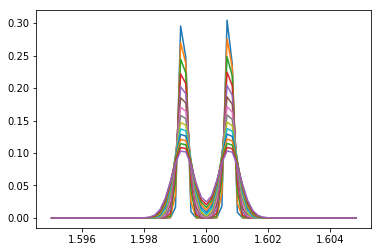

In [43]:
plt.plot(zgrid, tmp_model)
#plt.xlim([.49,.51])

In [31]:
Gaussian = lambda x, mean, std: np.exp(-((x[:, np.newaxis] - mean[:, np.newaxis])/std)**2)
wave_array = np.arange(4500, 5000, 1)
z_mean = np.arange(0.5, 1., .1)
width = np.arange(0.1, 0.5, .1)

#tmpval = Gaussian(wave_array, z_mean, width)
print(z_mean.shape);
print(width.shape)
print(z_mean[:, np.newaxis].shape)
print((z_mean[:, np.newaxis]/width))

(5,)
(4,)
(5, 1)
[[5.         2.5        1.66666667 1.25      ]
 [6.         3.         2.         1.5       ]
 [7.         3.5        2.33333333 1.75      ]
 [8.         4.         2.66666667 2.        ]
 [9.         4.5        3.         2.25      ]]


# -----------------------

In [ ]:
def modelFilter(z, width, Amp = 1):
    
    Gaussian = lambda x, mean, std: np.exp(-((x - mean)/std)**2)
    
    #Values from http://classic.sdss.org/dr6/algorithms/linestable.html
    separation = (3729.875-3727.092)/2 #separation between the emission lines
    lambda0 = 3727.092 + separation #Midpoint of the gaussian emission lines in restframe
    lambda_obs = lambda0*(1 + z) #Observed wavelength of of the midpoint
    
    models = []
        for i,j in enumerate(wavelength_array):
            models.append(Amp*(Gaussian(j, lambda0[i]-separation, width) + \
                               Gaussian(j, lambda0[i]+separation, width)))
            
        models = np.asarray(models)
        
        return models



def modelFilter(z, width, Amp = 1):
    
    Gaussian = lambda x, mean, std: np.exp(-((x - mean)/std)**2)
    
    #Values from http://classic.sdss.org/dr6/algorithms/linestable.html
    separation = (3729.875-3727.092)/2 #separation between the emission lines
    lambda0 = 3727.092 + separation #Midpoint of the gaussian emission lines in restframe
    lambda_obs = lambda0*(1 + z) #Observed wavelength of of the midpoint
    
    models = []
        for i,j in enumerate(wavelength_array):
            models.append(Amp*(Gaussian(j, lambda0[i]-separation, width) + \
                               Gaussian(j, lambda0[i]+separation, width)))
            
        models = np.asarray(models)
        
        return models

# Stopped May 31 2018. This means that we can truncate everything with the conditional z_grid >= 0 since we do not care about blueshift. This reduces memory load by 20%

In [166]:
def ModelO2(wavelength_array, width, Amp = 1):
        """Returns the [OII] doublet model
        Parameters: wavelength_array: Full wavelength array of MMT BinoSpec. This is constant and must be odd for lambda0 calc.
                    width: width of the Gaussian doublets. This varies.
                    Amp: Amplitude of the Gaussian doublets
        """

        Gaussian = lambda x, mean, std: np.exp(-((x - mean)/std)**2)

        #Values from http://classic.sdss.org/dr6/algorithms/linestable.html
        separation = (3729.875-3727.092)/2 #separation between lambda0 and the emission lines
        lambda0 = wavelength_array[(len(wavelength_array)+1)//2] #Take the midpoint of the wavelength_array as the centre
                                                                 #of the Gaussian doublet.wavelength_array must be odd
        return Amp*(Gaussian(wavelength_array, lambda0-separation, width) + Gaussian(wavelength_array, lambda0+separation, width))

In [230]:
def ModelO2loop(wavelength_array, width, Amp = 1):
        """Returns the [OII] doublet model
        Parameters: wavelength_array: Full wavelength array of MMT BinoSpec. This is constant and must be odd for lambda0 calc.
                    width: width of the Gaussian doublets. This varies.
                    Amp: Amplitude of the Gaussian doublets
        """
        
        Gaussian = lambda x, mean, std: np.exp(-((x[:, np.newaxis] - mean)/std)**2)

        #Values from http://classic.sdss.org/dr6/algorithms/linestable.html
        separation = (3729.875-3727.092)/2 #separation between lambda0 and the emission lines
        lambda0 = wavelength_array[:,(len(wavelength_array[0])+1)//2] #Take the midpoint of the wavelength_array as the centre
                                                                 #of the Gaussian doublet.wavelength_array must be odd
        #print(lambda0)
        models = []
        for i,j in enumerate(wavelength_array):
            models.append(Amp*(Gaussian(j, lambda0[i]-separation, width) + \
                               Gaussian(j, lambda0[i]+separation, width)))
            
        models = np.asarray(models)
        
        return models

In [240]:
print(tmpwindow[0])
print(ModelO2loop(tmpwindow,np.arange(.1, .5, .1))[0])
#plt.plot(ModelO2loop(tmpwindow,np.arange(.1, .5, .1))[0])

[4500 4502 4504 4506 4508]
[[0.00000000e+000 2.56087816e-231 3.27219758e-103 2.24955818e-058]
 [3.12040414e-296 1.32908486e-074 1.46562690e-033 3.39537837e-019]
 [8.30386925e-017 9.54597133e-005 1.63400503e-002 9.88450741e-002]
 [1.62104336e-084 1.89767202e-021 9.06899995e-010 1.11001229e-005]
 [8.30386925e-017 9.54597133e-005 1.63400503e-002 9.88450741e-002]]


In [182]:
def Window(wavelength_array, ngal, pixel_size, window_size_multiplier):
        """Returns windows to run the Model function over to speed up calculation
        Parameters: wavelength_array: Full wavelength array of MMT BinoSpec. This is constant
                    ngal: number of galaxies in a given data file
                    pixel_size: width of pixels in wavelength_array
                    window_size_multiplier: Multiple this with pixel size to get width of window in wavelength_array space
        Returns: nwindow_ndarray: l x m x n ndarray where l = ngal, m = number of windows and 
                                n = pixels per windowsize
        """

        nwindow = (wavelength_array[-1] - wavelength_array[0])//pixel_size #number of windows per galaxy. 
                                                        #It is of this form b/c beyond this window exceeds the wavelength_array
        nwindow_array = []

        #Generate nwindow windows
        print(wavelength_array[-1])
        for i in range(nwindow):
            tmp = np.arange(wavelength_array[i], wavelength_array[i] + pixel_size*(window_size_multiplier), \
                                         pixel_size)
            if(tmp[-1] > (wavelength_array[-1] + pixel_size)):
                break
            else:
                nwindow_array.append(tmp)

        nwindow_array = np.asarray(nwindow_array)
        
        #Repeat nwindow_arary ngal times 
        #https://stackoverflow.com/questions/32171917/copy-2d-array-into-3rd-dimension-n-times-python
        nwindow_ndarray = np.repeat(nwindow_array[np.newaxis, :, :], ngal, axis=0)

        #return nwindow_ndarray
        return nwindow_array

In [201]:
pixel_size = 2
wave_grid = np.arange(4500, 4600, pixel_size);
#print(len(wave_grid))
#print(wave_grid)
tmpwindow = Window(wave_grid, ngal = 1, pixel_size = pixel_size, window_size_multiplier=5)
tmpwindow[0]

4598


array([4500, 4502, 4504, 4506, 4508])

In [206]:
tmpmodel = ModelO2(tmpwindow[10], .1)

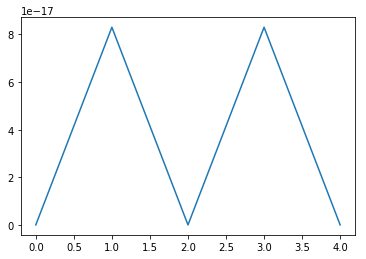

In [207]:
plt.plot(tmpmodel)

In [153]:
Gaussian = lambda x, mean, std: np.exp(-((x[:, np.newaxis] - mean)/std)**2)
vecGaussian = np.vectorize(Gaussian, excluded=['x'])

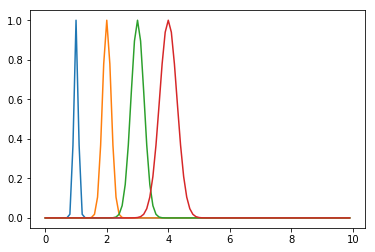

In [176]:
plt.plot(np.arange(0,10,.1), Gaussian(np.arange(0,10,.1), np.arange(1,5,1), np.arange(.1,.5,.1))) #np.arange(.1,.5,.1)))

In [179]:
Gaussian(np.arange(0,10,.1), np.arange(1,5,1), np.arange(.1,.5,.1)).shape

(100, 4)

In [208]:
for i in tmpwindow:
    print(i)

[4500 4502 4504 4506 4508]
[4502 4504 4506 4508 4510]
[4504 4506 4508 4510 4512]
[4506 4508 4510 4512 4514]
[4508 4510 4512 4514 4516]
[4510 4512 4514 4516 4518]
[4512 4514 4516 4518 4520]
[4514 4516 4518 4520 4522]
[4516 4518 4520 4522 4524]
[4518 4520 4522 4524 4526]
[4520 4522 4524 4526 4528]
[4522 4524 4526 4528 4530]
[4524 4526 4528 4530 4532]
[4526 4528 4530 4532 4534]
[4528 4530 4532 4534 4536]
[4530 4532 4534 4536 4538]
[4532 4534 4536 4538 4540]
[4534 4536 4538 4540 4542]
[4536 4538 4540 4542 4544]
[4538 4540 4542 4544 4546]
[4540 4542 4544 4546 4548]
[4542 4544 4546 4548 4550]
[4544 4546 4548 4550 4552]
[4546 4548 4550 4552 4554]
[4548 4550 4552 4554 4556]
[4550 4552 4554 4556 4558]
[4552 4554 4556 4558 4560]
[4554 4556 4558 4560 4562]
[4556 4558 4560 4562 4564]
[4558 4560 4562 4564 4566]
[4560 4562 4564 4566 4568]
[4562 4564 4566 4568 4570]
[4564 4566 4568 4570 4572]
[4566 4568 4570 4572 4574]
[4568 4570 4572 4574 4576]
[4570 4572 4574 4576 4578]
[4572 4574 4576 4578 4580]
[

## Synthetic data

In [ ]:
def Model(params, Amp = 1, std = 0.75): #Default, A = 1, std = 0.75
    """Returns the [OII] doublet model
    Parameters: Amp Amplitude
                params: tuple of spectra and lambda0 (centre point of the Model)
    """
    
    spectra, lambda0 = params
    Gaussian = lambda x, mean, std: np.exp(-((x - mean)/std)**2)
    
    #Values from http://classic.sdss.org/dr6/algorithms/linestable.html
    separation = (3729.875-3727.092)/2 #separation between lambda0 and the emission lines
    
    return Amp*(Gaussian(spectra, lambda0-separation, std) + Gaussian(spectra, lambda0+separation, std))

In [ ]:
wavelength_grid = np.arange(4500, 4550, .5) 
ngal = 64 #Number of galaxy in one data file

In [ ]:
synthSpectra = np.arange(4500, 5000, .5) #Note that spacing must be geq the minimum linewidth, i.e. 0.1
pureData = Model((synthSpectra, 4730), 1, .1)
errstd = 0.05
errData = np.random.normal(0, errstd, synthSpectra.shape)
synthData = pureData + errData

plt.subplot(2,1,1)
plt.plot(synthSpectra, synthData)
plt.plot(synthSpectra, pureData)
plt.xlabel("Wavelength", fontname = 'serif', fontsize = 15)
plt.ylabel("Flux", fontname = 'serif', fontsize = 15)

plt.subplot(2,1,2)
plt.plot(errData)
plt.xlabel("Wavelength", fontname = 'serif', fontsize = 15)
plt.ylabel("Flux Error", fontname = 'serif', fontsize = 15)

In [ ]:
def SNR_Calculatorv1(wavelength, flux, err):
    """Returns the SNR and lambda0 such that SNR is a function of lambda0
    Parameters: wavelength: array of wavelength range over which to test the filter
                flux: array of flux corresponding to the wavelength range
                err: array of flux error
                
    Returns: SNR: Signal-to-noise ratios of Amplitude
             lambda0: Different central values of the filter
    """
    
    lambda0_emitted = 3727.092 + (3729.875-3727.092)/2 #Midpoint of OII doublet
        
    #Initialise numpy arrays
    width = np.arange(0.1, 2.1, .1) #To calculate SNR at different linewidth
    z = np.zeros(len(wavelength))
    SNR = np.zeros((len(width), len(wavelength))) #width vs z grid
    dataPrime = flux/err #signal of data
    
    #Calculate SNR at different lambda0 and w
    for i in range(len(wavelength)):
        for j in range(len(width)):
            lambda0 = wavelength[i]
            modelFlux = Model((wavelength, lambda0), 1, width[j])
            modelPrime = modelFlux/err
            
            """A = (fluxPrime (dot) modelPrime)/(modelPrime (dot) modelPrime)
            sigmaA = 1/sqrt(modelPrime (dot) modelPrime)
            SNR = A/sigmaA"""
            sigmaA = 1./np.sqrt(np.dot(modelPrime, modelPrime))
            A = np.dot(dataPrime, modelPrime)/(sigmaA**(-2))
            SNR[j][i] = A/sigmaA
            
        #Convert lambda0 to z
        z[i] = lambda0/lambda0_emitted - 1
    
    return SNR, z, width

In [ ]:
import time

In [ ]:
t0 = time.time()
SNRv1, z, w = SNR_Calculatorv1(synthSpectra, synthData, errstd)
t1 = time.time()
totalv1 = t1-t0

In [ ]:
def SNR_Calculatorv2(wavelength, flux, err):
    """Returns the SNR and lambda0 such that SNR is a function of lambda0
    Parameters: wavelength: array of wavelength range over which to test the filter
                flux: array of flux corresponding to the wavelength range
                err: array of flux error
                
    Returns: SNR: Signal-to-noise ratios of Amplitude
             lambda0: Different central values of the filter
    """
    
    lambda0_emitted = 3727.092 + (3729.875-3727.092)/2 #Midpoint of OII doublet
        
    #Initialise numpy arrays
    width = np.arange(0.1, 2.1, .1) #To calculate SNR at different linewidth
    z = np.zeros(len(wavelength))
    SNR = np.zeros((len(width), len(wavelength))) #width vs z grid
    dataPrime = flux/err #signal of data
    #Calculate SNR at different lambda0 and w
    for i in range(len(wavelength)-50): 
        #The window is 100 px wide with centre at the 50th px. Hence we go upto nth-50 such that we do not have index error
        for j in range(len(width)):
            lambda0 = wavelength[i+50]
            modelFlux = Model((wavelength[i:i+100], lambda0), 1, width[j])
            modelPrime = modelFlux/err
            
            """A = (fluxPrime (dot) modelPrime)/(modelPrime (dot) modelPrime)
            sigmaA = 1/sqrt(modelPrime (dot) modelPrime)
            SNR = A/sigmaA"""
            sigmaA = 1./np.sqrt(np.dot(modelPrime, modelPrime))
            A = np.dot(dataPrime[i:i+100], modelPrime)/(sigmaA**(-2))
            SNR[j][i] = A/sigmaA
            
        #Convert lambda0 to z
        z[i] = lambda0/lambda0_emitted - 1
    
    return SNR, z, width

In [ ]:
t0 = time.time()
SNRv2, z, w = SNR_Calculatorv2(synthSpectra, synthData, errstd)
t1 = time.time()
totalv2 = t1-t0

In [ ]:
print(totalv1)
print(totalv2)

In [ ]:
import seaborn as sns

In [ ]:
plt.imshow(SNRv1, aspect = 'auto')

In [ ]:
np.where(SNRv1 == SNRv1.max())

In [ ]:
plt.imshow(SNRv2, aspect = 'auto')

In [ ]:
np.where(SNRv2 == SNRv2.max())

In [ ]:
SNRv2[0][410]

In [ ]:
SNRv1[0][460]

In [ ]:
plt.plot(ModelO2(np.arange(4500,4560,.5), .5))